In [1]:
import tclab
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gekko import GEKKO

In [2]:
n = 600
t  = np.linspace(0,n,n+1)
Q1 = np.zeros(n+1)
Q1[10:] = 70; Q1[200:] = 30; Q1[400:] = 80; Q1[550:]=0
T1 = np.empty_like(t)

lab = tclab.TCLab()

for i in range(n+1):
    time.sleep(1)
    lab.Q1(Q1[i])
    T1[i] = lab.T1
    if i%10==0:
        print(Q1[i],T1[i])
    
lab.close()

TCLab version 0.4.9
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.
0.0 22.2
70.0 22.2
70.0 22.84
70.0 24.77
70.0 27.35
70.0 29.93
70.0 33.15
70.0 35.09
70.0 37.67
70.0 40.24
70.0 42.82
70.0 44.76
70.0 46.69
70.0 48.3
70.0 49.59
70.0 51.52
70.0 52.81
70.0 54.1
70.0 54.75
70.0 56.36
30.0 57.0
30.0 58.29
30.0 57.97
30.0 57.0
30.0 56.36
30.0 55.71
30.0 54.43
30.0 52.81
30.0 52.17
30.0 51.2
30.0 50.24
30.0 49.91
30.0 48.95
30.0 48.95
30.0 48.62
30.0 48.62
30.0 48.3
30.0 47.98
30.0 47.66
30.0 47.01
80.0 47.33
80.0 47.01
80.0 47.98
80.0 49.27
80.0 50.88
80.0 53.14
80.0 55.07
80.0 57.0
80.0 58.94
80.0 60.55
80.0 61.84
80.0 62.48
80.0 63.77
80.0 64.74
80.0 66.03
0.0 66.67
0.0 66.99
0.0 66.03
0.0 64.42
0.0 61.52
0.0 59.26
TCLab disconnected successfully.


In [3]:
import os
print(os.getcwd())

C:\Users\johnh\Desktop\Solutions


In [4]:
data = np.vstack((t,Q1,T1))
np.savetxt('TCLab_data.csv',data.T,delimiter=',',header='time,Q,T',comments='')

import pandas as pd
data = pd.read_csv('TCLab_data.csv')
data.describe()

,time,Q,T
count,601.000000,601.000000,601.000000
mean,300.000000,52.079867,50.426639
std,173.638033,27.107815,10.996648
min,0.000000,0.000000,22.200000
25%,150.000000,30.000000,47.330000
50%,300.000000,70.000000,51.200000
75%,450.000000,70.000000,57.650000
max,600.000000,80.000000,67.320000


U: 3.3211954078
alpha: 0.0081936554485


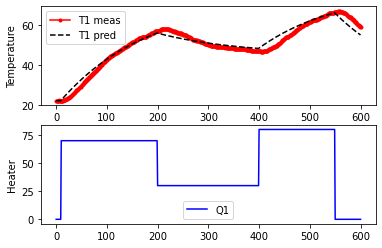

In [5]:
m = GEKKO()

m.time = t
T = m.Var(T1[0])
TK = m.Var(T1[0]+273.15)
Q = m.Param(Q1)

U = m.FV(5,lb=1,ub=20); U.STATUS = 1
alpha = m.FV(0.01,lb=0.005,ub=0.05); alpha.STATUS=1

Cp = 500; A = 1.2e-3; mass = 0.004
eps = 0.9; sigma = 5.67e-8; Tinf=296.15
m.Equation(TK==T+273.15)
m.Equation(mass*Cp*T.dt()==U*A*(Tinf-TK)\
           +eps*sigma*A*(Tinf**4-TK**4) \
           +alpha*Q)

Tm = m.Param(T1)
m.Minimize((T-Tm)**2)

m.options.IMODE=5
m.solve(disp=False)

plt.subplot(2,1,1)
plt.plot(t,T1,'r.-',label='T1 meas')
plt.plot(t,T,'k--',label='T1 pred')
plt.legend(); plt.ylabel('Temperature')
plt.subplot(2,1,2)
plt.plot(t,Q1,'b-',label='Q1')
plt.legend(); plt.ylabel('Heater')

print('U: ' + str(U.value[0]))
print('alpha: ' + str(alpha.value[0]))

In [6]:
na = 2; nb = 2
Tp,p,K = m.sysid(t,Q1,T1,na,nb)

Text(0, 0.5, 'Heater')

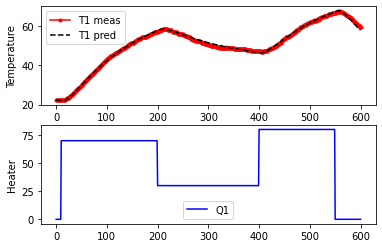

In [7]:
plt.subplot(2,1,1)
plt.plot(t,T1,'r.-',label='T1 meas')
plt.plot(t,Tp,'k--',label='T1 pred')
plt.legend(); plt.ylabel('Temperature')
plt.subplot(2,1,2)
plt.plot(t,Q1,'b-',label='Q1')
plt.legend(); plt.ylabel('Heater')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Load training data
file = 'https://apmonitor.com/do/uploads/Main/tclab_dyn_data3.txt'
train = pd.read_csv(file)

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(train[['T1','Q1']])

# Scale predicted value
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(train[['T1']])

# Each time step uses last 'window' to predict the next change
window = 70
X = []
Y = []
for i in range(window,len(Xs)):
    X.append(Xs[i-window:i,:])
    Y.append(Ys[i])

# Reshape data to format accepted by LSTM
X, Y = np.array(X), np.array(Y)

# create and train LSTM model

# Initialize LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, \
          input_shape=(X.shape[1],X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])

# Allow for early exit 
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# Fit (and time) LSTM model
t0 = time.time()
history = model.fit(X, Y, epochs = 10, batch_size = 250, callbacks=[es], verbose=1)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

# Plot loss 
plt.figure(figsize=(8,4))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')
plt.savefig('tclab_loss.png')
model.save('model.h5')

# Verify the fit of the model
Yp = model.predict(X)

# un-scale outputs
Yu = s2.inverse_transform(Yp)
Ym = s2.inverse_transform(Y)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(train['Time'][window:],Yu,'r-',label='LSTM')
plt.plot(train['Time'][window:],Ym,'k--',label='Measured')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.subplot(2,1,2)
plt.plot(train['Q1'],label='heater (%)')
plt.legend()
plt.xlabel('Time (sec)'); plt.ylabel('Heater')
plt.savefig('tclab_fit.png')

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>

In [ ]:
# Load model
v = load_model('model.h5')
# Load training data
test = pd.read_csv('TCLab_data.csv')

Xt = test[['T','Q']].values
Yt = test[['T']].values

Xts = s1.transform(Xt)
Yts = s2.transform(Yt)

Xti = []
Yti = []
for i in range(window,len(Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

# Reshape data to format accepted by LSTM
Xti, Yti = np.array(Xti), np.array(Yti)

# Verify the fit of the model
Ytp = model.predict(Xti)

# un-scale outputs
Ytu = s2.inverse_transform(Ytp)
Ytm = s2.inverse_transform(Yti)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(test['time'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['time'][window:],Ytm,'k--',label='Measured')
plt.legend()
plt.ylabel('Temperature (°C)')
plt.subplot(2,1,2)
plt.plot(test['time'],test['Q'],'b-',label='Heater')
plt.xlabel('Time (sec)'); plt.ylabel('Heater (%)')
plt.legend()
plt.savefig('tclab_validate.png')

# Using predicted values to predict next step
Xtsq = Xts.copy()
for i in range(window,len(Xtsq)):
    Xin = Xtsq[i-window:i].reshape((1, window, 2))
    Xtsq[i][0] = v.predict(Xin)
    Yti[i-window] = Xtsq[i][0]

#Ytu = (Yti - s2.min_[0])/s2.scale_[0]
Ytu = s2.inverse_transform(Yti)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(test['time'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['time'][window:],Ytm,'k--',label='Measured')
plt.legend()
plt.ylabel('Temperature (°C)')
plt.subplot(2,1,2)
plt.plot(test['time'],test['Q'],'b-',label='Heater')
plt.xlabel('Time (sec)'); plt.ylabel('Heater (%)')
plt.legend()
plt.savefig('tclab_forecast.png')
plt.show()